In this code example, we'll compute the control forces required for a 3D quadrotor camera to follow a look-from look-at trajectory.

In [1]:
%pylab inline
from pylab import *

import control
import mpl_toolkits.mplot3d
import scipy.integrate

import path_utils
path_utils.add_relative_to_current_source_file_path_to_sys_path("../../lib")

import flashlight.curve_utils           as curve_utils
import flashlight.interpolate_utils     as interpolate_utils
import flashlight.ipython_display_utils as ipython_display_utils
import flashlight.quadrotor_camera_3d   as quadrotor_camera_3d
import flashlight.spline_utils          as spline_utils

Populating the interactive namespace from numpy and matplotlib
Initializing flashlight v0.0.1
flashlight.quadrotor_camera_3d: Constructing sympy symbols...
flashlight.quadrotor_camera_3d: Finished constructing sympy symbols (0.011 seconds).
flashlight.quadrotor_camera_3d: Loading sympy modules...
flashlight.quadrotor_camera_3d: Finished loading sympy modules (0.007 seconds).


/Users/mike/Code/GitHub/flashlight/code/lib/flashlight/transformations.py:1888: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


We begin by computing a trajectory for the quadrotor (i.e., a _look-from_ trajectory), exactly as we did in our previous examples.

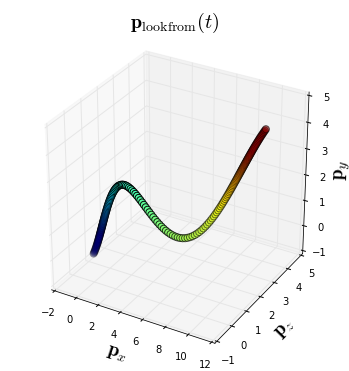

In [2]:
T_z = matrix([0,1,2,3]).T.A
T_y = matrix([0,1,2,3]).T.A
T_x = matrix([0,1,2,3]).T.A
T   = c_[T_z, T_y, T_x]
P_z = matrix([0,0,1,4]).T.A
P_y = matrix([0,3,1,4]).T.A
P_x = matrix([0,3,7,10]).T.A
P   = c_[P_z, P_y, P_x]

num_samples = 200

C, T, sd = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P, T, degree=7, lamb=[0,0,0,1,0])
    
P_eval, T_eval, dT = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C, T, sd, num_samples=num_samples)

T_s = matrix([0.0,1.2,1.8,3.0]).T.A
P_s = matrix([0.0,0.3,0.7,1.0]).T.A

C_s, T_s, sd_s = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P_s, T_s, degree=7, lamb=[0,0,0,1,0])
    
P_s_eval, T_s_eval, dT_s = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C_s, T_s, sd_s, num_samples=num_samples)

t = linspace(0.0,10.0,num_samples)
s_spline = P_s_eval

P_eval_spline, t_spline, P_eval_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s_spline)

p_look_from = P_eval_spline

figsize(6,6);
fig = plt.figure();
ax = fig.add_subplot(111, projection="3d");
ax.scatter(P_eval_spline[:,2], P_eval_spline[:,0], P_eval_spline[:,1], c=t, s=50);
title("$\\mathbf{p}_{\\mathrm{lookfrom}}(t)$\n", fontsize=20);
ax.set_zlabel("$\\mathbf{p}_y$", fontsize=20);
xlabel("$\\mathbf{p}_x$", fontsize=20); ylabel("$\\mathbf{p}_z$", fontsize=20);

Next, we compute a trajectory for the object we want to look at (i.e., a _look-at_ trajectory). For simplicity, we use the same progress curve as we used to compute our look-from trajectory.

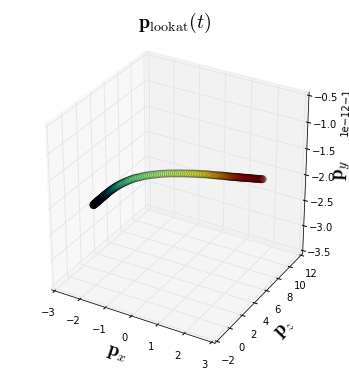

In [3]:
T_z = matrix([0,1,2,3]).T.A
T_y = matrix([0,1,2,3]).T.A
T_x = matrix([0,1,2,3]).T.A
T   = c_[T_z, T_y, T_x]
P_z = matrix([0,3,7,10]).T.A
P_y = matrix([-1,-1,-1,-1]).T.A
P_x = matrix([-2,-2,-1,2]).T.A
P   = c_[P_z, P_y, P_x]

num_samples = 200

C, T, sd = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P, T, degree=7, lamb=[0,0,0,1,0])
    
P_eval, T_eval, dT = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C, T, sd, num_samples=num_samples)

P_eval_spline, t_spline, P_eval_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s_spline)

p_look_at = P_eval_spline

figsize(6,6);
fig = plt.figure();
ax = fig.add_subplot(111, projection="3d");
ax.scatter(P_eval_spline[:,2], P_eval_spline[:,0], P_eval_spline[:,1], c=t, s=50);
title("$\\mathbf{p}_{\\mathrm{lookat}}(t)$\n", fontsize=20);
ax.set_zlabel("$\\mathbf{p}_y$", fontsize=20);
xlabel("$\\mathbf{p}_x$", fontsize=20); ylabel("$\\mathbf{p}_z$", fontsize=20);

As in our previous examples, we compute a state space trajectory, and then a control trajectory. Note that computing a state space trajectory for a 3D quadrotor camera requires that we specify a look-from trajectory, a look-at trajectory, and an up vector hint (the up vector hint is used to determine the camera roll). In this example, we set the up vector hint to be the global up vector, which has the effect of keeping the ground plane horizontal in screen space. For more details on the control problem being solved here, see [1].

#### References

[1] Niels Joubert, Mike Roberts, Anh Truong, Floraine Berthouzoz, Pat Hanrahan. An Interactive Tool for Designing Quadrotor Camera Shots. _ACM Transactions on Graphics 34(6) (SIGGRAPH Asia 2015)_.

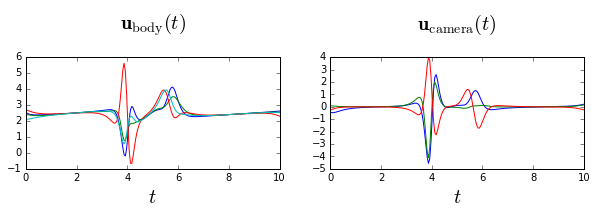

In [4]:
t_begin       = t[0]
t_end         = t[-1]
num_timesteps = num_samples

dt = (t_end-t_begin) / (num_timesteps-1)

y_axis_cam_hint = c_[ zeros_like(t), ones_like(t), zeros_like(t) ]

q_qdot_qdotdot = quadrotor_camera_3d.compute_state_space_trajectory_and_derivatives(p_look_from, p_look_at, y_axis_cam_hint, dt)
u              = quadrotor_camera_3d.compute_control_trajectory(q_qdot_qdotdot)

figsize(10,2)

subplot(121);
plot(t, u[:,0]); plot(t, u[:,1]); plot(t, u[:,2]); plot(t, u[:,3]);
title("$\\mathbf{u}_{\\mathrm{body}}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

subplot(122);
plot(t, u[:,4]); plot(t, u[:,5]); plot(t, u[:,6]);
title("$\\mathbf{u}_{\\mathrm{camera}}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

We can simulate our control trajectory exactly as in our previous examples. The moving white dot is our look-at point. The long red, green, and blue lines extending out from the quadrotor, are the x, y, and z axes of the camera frame. The long red line is the camera's look-at vector, and the long blue line is the camera's right vector. If we have computed all our control forces correctly, the quadrotor should stay on it's intended trajectory, it should always be looking at the white dot, the quadrotor's yaw angle should match the camera's yaw angle, and the camera's right vector should always be oriented horizontally.

As in our previous examples, we notice some simulation drift. Again, because we compute control forces numerically (i.e., inexactly), and we perform numerical (i.e., inexact) integration in our simulation, and we don't apply any feedback control, a small amount of drift is expected. As in our previous examples, we'll apply time-varying LQR feedback control to elimate simulation drift.

In [5]:
x_nominal, q_nominal, qdot_nominal, qdotdot_nominal = \
    quadrotor_camera_3d.pack_state_space_trajectory_and_derivatives(q_qdot_qdotdot)

p_look_at_nominal = p_look_at

x_0 = x_nominal[0]

def compute_x_dot(x_t, t):

    x_t     = matrix(x_t).T
    u_t     = u_interp_func(clip(t, t_begin, t_end))
    x_dot_t = quadrotor_camera_3d.compute_x_dot(x_t, u_t).A1
    
    return x_dot_t

num_timesteps_sim = 200
t_sim             = linspace(t_begin, t_end, num_timesteps_sim)
u_interp_func     = interpolate_utils.interp1d_vector_wrt_scalar(t, u, kind="cubic")
x_sim             = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

quadrotor_camera_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, p_look_at_nominal=p_look_at_nominal)
# quadrotor_camera_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, p_look_at_nominal=p_look_at_nominal, savefig=True, out_dir="data/12", out_file="00.mp4")
ipython_display_utils.get_inline_video("data/12/00.mp4")

/Users/mike/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/traits/has_traits.py:1536: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )
/Users/mike/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/traits/has_traits.py:1541: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


Finally, we apply time-varying LQR to eliminate simulation drift.

In [6]:
x_nominal, q_nominal, qdot_nominal, qdotdot_nominal = \
    quadrotor_camera_3d.pack_state_space_trajectory_and_derivatives(q_qdot_qdotdot)

p_look_at_nominal = p_look_at

u_nominal = u

x_0 = x_nominal[0]

Q = diag([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
R = diag([1,1,1,1,1,1,1])

def compute_x_dot(x_t, t):

    x_t = matrix(x_t).T
    
    x_nominal_t = x_nominal_interp_func(clip(t, t_begin, t_end))
    u_nominal_t = u_nominal_interp_func(clip(t, t_begin, t_end))
    
    A_t, B_t      = quadrotor_camera_3d.compute_df_dx_and_df_du(x_nominal_t, u_nominal_t)
    K_t, S_t, E_t = control.lqr(A_t, B_t, Q, R)
    
    x_bar_t = x_t - x_nominal_t
    u_bar_t = -K_t*x_bar_t
    u_t     = u_bar_t + u_nominal_t
    x_dot_t = quadrotor_camera_3d.compute_x_dot(x_t, u_t).A1
    
    return x_dot_t

num_timesteps_sim     = 200
t_sim                 = linspace(t_begin, t_end, num_timesteps_sim)
x_nominal_interp_func = interpolate_utils.interp1d_vector_wrt_scalar(t, x_nominal, kind="cubic")
u_nominal_interp_func = interpolate_utils.interp1d_vector_wrt_scalar(t, u_nominal, kind="cubic")
x_sim                 = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

quadrotor_camera_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, p_look_at_nominal=p_look_at_nominal)
# quadrotor_camera_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, p_look_at_nominal=p_look_at_nominal, savefig=True, out_dir="data/12", out_file="01.mp4")
ipython_display_utils.get_inline_video("data/12/01.mp4")